In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
sys.path.append('../')
from fastai.vision import *
from modules.basics import *
from PIL import Image, ImageDraw, ImageFont
from concurrent.futures import ProcessPoolExecutor
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [3]:
IMG_PATH, DATA_PATH

(PosixPath('/home/giles/Documents/kaggle/higgsml'), PosixPath('../data'))

In [4]:
IMG_PATH = DATA_PATH/'iris'

In [5]:
iris = load_iris()
df = pd.DataFrame(data=np.c_[iris['data'], iris['target']].astype('float32'),
                  columns=iris['feature_names'] + ['target'])
df.target = df.target.values.astype(int)

In [6]:
train_feats = iris['feature_names']; print(len(df));df.head()

150


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
font = ImageFont.truetype('FreeMonoBold.ttf', 13)

In [8]:
def event2img(event:np.ndarray, size:int=224) -> PIL.Image.Image:
    img = Image.fromarray(np.zeros([size,size,3]), 'RGB')
    for i, f in enumerate(event):
        ImageDraw.Draw(img).text((((1/3)+(i%2))*size//2,(size//5)+((i//2)*2*size//len(event))), f'{f:.1f}', fill=(255,255,255), font=font)
    return img

CPU times: user 3.65 ms, sys: 2.81 ms, total: 6.45 ms
Wall time: 38 ms


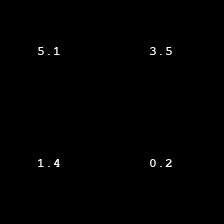

In [9]:
%%time
event2img(df[train_feats].values[0])

In [10]:
for mode in ['train']: os.makedirs(IMG_PATH/'images'/mode, exist_ok=True)

In [11]:
def save_image(event:np.ndarray, name:Union[str, int, float], loc:Path, size:int=224) -> None:
    img = event2img(event, size)
    name = str(name)
    if '.' not in name: name += '.png'
    img.save(loc/name)

In [12]:
def proc_sample(df:pd.DataFrame, mode:str, size:int=224) -> None:
    func = partial(save_image, loc=IMG_PATH/'images'/mode, size=size)
    with ProcessPoolExecutor(10) as e: e.map(func, df[train_feats].values, df.index.values)

In [13]:
%%time
proc_sample(df, 'train')

CPU times: user 61.6 ms, sys: 81.7 ms, total: 143 ms
Wall time: 171 ms


In [14]:
df.reset_index(inplace=True)
df.rename(columns={'index':'image_name'}, inplace=True)
df.to_csv(IMG_PATH/'train.csv', index=False)